# Part 2_2. DEAP Dataset + Spectral Analysis + SVM With MNE_feature

Continuing from Part2_1., this part we will explore another library called [`mne_features`](https://mne.tools/mne-features/index.html). This library aims to extract features out of the epochs-like data (n_epochs, n_channels, n_samples).

We could skip the entire `MNE` library if our data is preprocessed like this DEAP dataset.

In [2]:
import pickle
import numpy as np

# this time I will load the Dataset class from `./components/dataset.py`
from components.dataset import Dataset

In [3]:
path = "data"
dataset = Dataset(path, "Valence")

data  = np.array(dataset[:]['data'])
label = np.array(dataset[:]['label'])

print("Data shape: " , data.shape)  #15360 = 32 participants * 40 trials * 12 segments, 32 EEG channels, 672 samples
print("Label shape: ", label.shape)  #two classes of valence
print(f"{sum(label==0)=} + {sum(label==1)=} = {sum(label==0)+sum(label==1)}")

del(dataset)

Data shape:  (15360, 32, 672)
Label shape:  (15360, 1)
sum(label==0)=array([6864]) + sum(label==1)=array([8496]) = [15360]


# MNE_features

In [23]:
from mne_features.feature_extraction import FeatureExtractor
import time

In [6]:
# mne_features.univariate.compute_mean: Mean of the data (per channel).
start = time.time()
fe = FeatureExtractor(sfreq=128, selected_funcs=['mean'])
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

# mne_features.univariate.compute_variance: Variance of the data (per channel).
start = time.time()
fe = FeatureExtractor(sfreq=128, selected_funcs=['variance'])
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

# mne_features.univariate.compute_ptp_amp: Peak-to-peak (PTP) amplitude of the data (per channel).
start = time.time()
fe = FeatureExtractor(sfreq=128, selected_funcs=['ptp_amp'])
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

(15360, 32) 6.546555280685425
(15360, 32) 6.762385845184326
(15360, 32) 5.830480575561523


In [15]:
# You can extract everything in one go (well, it just do a loop for you)
start = time.time()
fe = FeatureExtractor(sfreq=128, selected_funcs=['mean','variance','ptp_amp'])
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

(15360, 96) 11.249577522277832


In [16]:
# We can set parallel with n_jobs
start = time.time()
fe = FeatureExtractor(sfreq=128, selected_funcs=['mean','variance','ptp_amp'],n_jobs=3)
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

(15360, 96) 5.23874568939209


In [20]:
# You can provide the memeory argument (which is a path to store cache). Everytime you rerun the Extractor, it will fetch from the cache
start = time.time()
fe = FeatureExtractor(sfreq=128, selected_funcs=['mean','variance','ptp_amp'],n_jobs=3,memory='cache/')
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

start = time.time()
fe = FeatureExtractor(sfreq=128, selected_funcs=['mean','variance','ptp_amp'],n_jobs=3,memory='cache/')
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

________________________________________________________________________________
[Memory] Calling mne_features.feature_extraction.extract_features...
extract_features(array([[[  0.948232, ...,   1.381568],
        ...,
        [  0.372271, ...,  -0.810515]],

       ...,

       [[ -1.971357, ...,   2.64132 ],
        ...,
        [  0.722246, ..., -10.919237]]], dtype=float32), 
128, ['mean', 'variance', 'ptp_amp'], funcs_params=None, n_jobs=3)


/root/projects/.venv/lib/python3.8/site-packages/mne_features/feature_extraction.py:386: UserWarning: Persisting input arguments took 1.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  return _extractor(X, self.sfreq, self.selected_funcs,


_________________________________________________extract_features - 6.8s, 0.1min
(15360, 96) 10.048383474349976
(15360, 96) 1.6996862888336182


# Extract PSD with MNE_features



https://mne.tools/mne-features/generated/mne_features.univariate.compute_pow_freq_bands.html#mne_features.univariate.compute_pow_freq_bands

The `compute_pow_freq_bands` has optional parameters.

Before we go stright to the `FeatureExtractor` pipeline, it is easier to play with the function directly (for me)

In [28]:
from mne_features.univariate import compute_pow_freq_bands
import matplotlib.pyplot as plt

# The `compute_pow_freq_bands` expects data to be in a shape of (n_channels, n_samples). 
# I want to extract the information with base-10 log and no normalize. (please read the manual for more information)
start = time.time()
psd_0 = compute_pow_freq_bands(sfreq=128, data=data[0], freq_bands=np.array([0.5,4.]), log=True , normalize=False)
print(psd_0.shape, time.time() - start)

(32,) 0.0038406848907470703


To pass the optional parameter to a specific function, the `params` argument is needed.

Since we can have multiple function (mean,variance,std,...) in the `selected_funcs`, the `params` needs to be in a form of dictionary with key in a format of `<func_name>__<param_name>`

If I want to pass a paremeter of `log` for `pow_freq_bands` then the key is `pow_freq_bands__log`. The associated value is the value you want to pass.

In [34]:
start = time.time()
# [alias_feature_function]__[optional_param]
params = dict({
    'pow_freq_bands__log':True,
    'pow_freq_bands__normalize':False,
    'pow_freq_bands__freq_bands':np.array([0.5,4.])
})
fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'],params=params,n_jobs=8)
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

(15360, 32) 4.470647573471069


The `FeatureExtractor` loops through the epochs and calculate `pow_freq_bands`. Since we use `n_jobs`, the time we spent is faster than write a loop yourself.

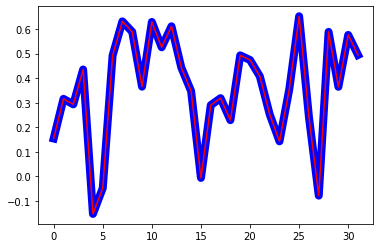

In [43]:
# And the data is exactly the same.
plt.plot(X[0], color='b', linewidth=8)
plt.plot(psd_0, color='r')
plt.show()

Now, need to understand `freq_bands` and why the current argument result in a shape of (32,).

I could just go write a bunch of code and let you figure out (I know you can) or I will explain right now.

I don't know why I wrote the above sentence but here we go.

There are `3` ways you can define `freq_bands`.

```
1. np.array( [.5, 4, 8] )
2. np.array( [
    [.5,4],
    [4,8]
])
3. dict({
    'delta': [.5,4],
    'theta': [4,8]
})
```

Previously, the I only pass [.5,4] so there is only one band that is extracted. The shape (32,) is a the value of [.5,4] in those channels.

Ah.. If we pass all bands, we will get (32,5)?

Actually, no. See for yourself.

In [44]:
start = time.time()
# [alias_feature_function]__[optional_param]
params = dict({
    'pow_freq_bands__log':True,
    'pow_freq_bands__normalize':False,
    'pow_freq_bands__freq_bands':dict({
        'delta': [.5,4],
        'theta': [4,8]
    })
})
fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'],params=params,n_jobs=8)
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

(15360, 64) 34.27146863937378


GGWP.

This is understandable since the return data is `sklearn`-ready (n_epochs, features).

Is this a bad thing? no... Well, that depends on what you want, if you want to later futhur summarize the data then probably yes.

Since we are here now, why don't we give this a try in SVM

## 3. Machine Learning

In [45]:
from mne_features.feature_extraction import FeatureExtractor
import time
start = time.time()

bands = [(0,4), (4,8), (8,12), (12,30), (30,64)]
# [alias_feature_function]__[optional_param]
params = dict({
    'pow_freq_bands__log':True,
    'pow_freq_bands__normalize':False,
    'pow_freq_bands__freq_bands':bands
})
fe = FeatureExtractor(sfreq=128, selected_funcs=['pow_freq_bands'],params=params,n_jobs=8)
X = fe.fit_transform(X=data)
print(X.shape, time.time() - start)

(15360, 160) 40.66635036468506


In [50]:
y = label.squeeze()
y.shape

(15360,)

In [47]:
def train_model(X_ori,y_ori, kernel='rbf'):
    # Make a copy because I am paranoid
    X,y = X_ori.copy(), y_ori.copy()

    from sklearn.svm import SVC
    from sklearn.utils import shuffle
    from sklearn.model_selection import cross_val_score

    # 
    X_shuff,y_shuff = shuffle(X,y)
    model = SVC(kernel=kernel,max_iter=10000)
    cross = cross_val_score(model, X_shuff, y_shuff, cv=3)

    model = SVC(kernel=kernel, max_iter=10000)
    model.fit(X_shuff, y_shuff)
    ans = model.predict(X_shuff)
    acc = sum(ans == y_shuff) / len(y_shuff)
    return model, acc, cross

In [51]:
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(X, y, kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Kernel=linear| Acc=0.53197 | 3-CV score=0.5304 STD=0.02003| Time spend=44.6980504989624


/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/root/projects/.venv/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


	Kernel=poly| Acc=0.63346 | 3-CV score=0.60326 STD=0.03844| Time spend=53.509968996047974
	Kernel=rbf| Acc=0.70436 | 3-CV score=0.67168 STD=0.00306| Time spend=97.64887022972107
	Kernel=sigmoid| Acc=0.52975 | 3-CV score=0.52988 STD=0.00428| Time spend=52.1804633140564


Seem like having features as `n_channels * freq_bands` is a better approach for this dataset.

However, Having too many features could lead to various problem. As told before, the challenge of this work is to find the a combination of technique that yield the best result without biasing.